In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [4]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures

c:\Users\Lukas\Projetos\Machine-Learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
dataset_path = '../../datasets/AEP_hourly.csv'

In [29]:
df = pd.read_csv(dataset_path, delimiter=',')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [30]:
df = df.rename(columns={'Datetime': 'date'})
df = df.drop_duplicates(subset='date', keep='first')
df.head()

,date,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [31]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('date')
df = df.asfreq('H', fill_value=0.0)
df = df.sort_index()

C:\Users\Lukas\AppData\Local\Temp\ipykernel_10624\2275917043.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H', fill_value=0.0)


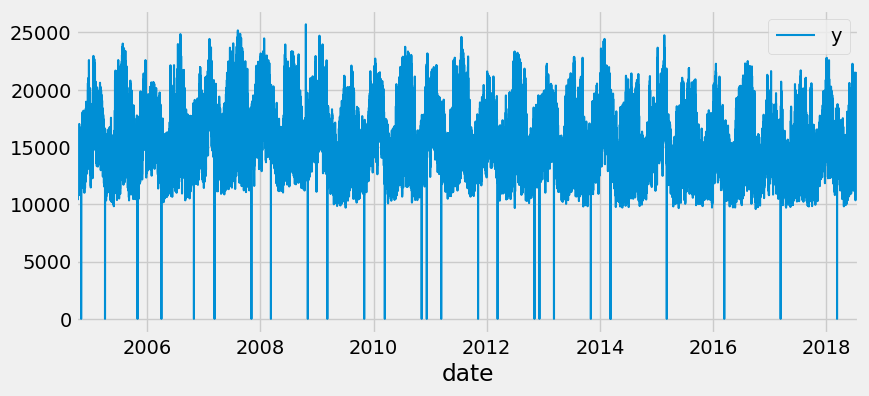

In [34]:
fig, ax = plt.subplots(figsize=(9, 4))
df['AEP_MW'].plot(ax=ax, label='y')
# df['exog_1'].plot(ax=ax, label='exogenous variable')
ax.legend()

Train dates : 2004-10-01 01:00:00 --- 2018-08-01 12:00:00  (n=121260)
Test dates  : 2018-08-01 13:00:00 --- 2018-08-03 00:00:00  (n=36)


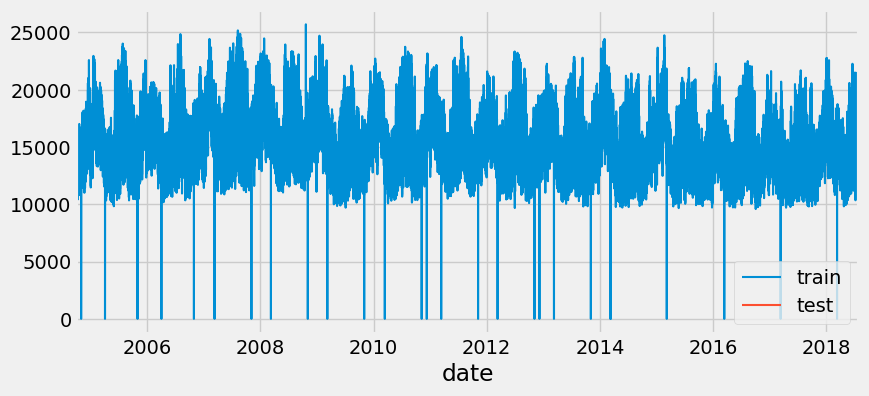

In [40]:
steps = 36
data_train = df[:-steps]
data_test  = df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['AEP_MW'].plot(ax=ax, label='train')
data_test['AEP_MW'].plot(ax=ax, label='test')
ax.legend()

In [42]:
forecaster = ForecasterRecursive(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123),
                lags      = 12,
                window_features = RollingFeatures(stats=['mean'], window_sizes=10)
             )

forecaster.fit(y=data_train['AEP_MW'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Window features: ['roll_mean_10'] 
Window size: 12 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2004-10-01 01:00:00'), Timestamp('2018-08-01 12:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-21 15:49:09 
Last fit date: 2025-04-21 15:49:48 
Skforecast version: 0.15.1 
Python version: 3.12.4 
Forecaster id: None

In [ ]:
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2018-08-01 13:00:00    16340.502036
2018-08-01 14:00:00    16380.395168
2018-08-01 15:00:00    16236.621089
2018-08-01 16:00:00    16056.477385
2018-08-01 17:00:00    15865.008276
Freq: h, Name: pred, dtype: float64

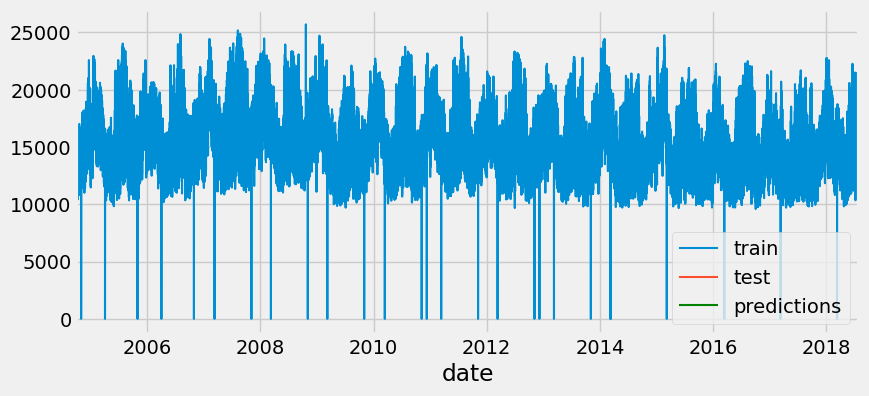

In [47]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train['AEP_MW'].plot(ax=ax, label='train')
data_test['AEP_MW'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend()